In [ ]:
import pandas as pd
import sklearn as sk
import numpy as np
import keras
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [193]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [194]:
train_set.set_index('Id',inplace = True)
test_set.set_index('Id',inplace = True)
train_set.head(5)
test_set.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [195]:
for i in train_set.columns:
    if train_set[i].dtype == object:
        train_set[i] = train_set[i].astype('category')


In [196]:
for i in test_set.columns:
    if test_set[i].dtype == object:
        test_set[i] = test_set[i].astype('category')

In [198]:
print(test_set.dtypes)

MSSubClass          int64
MSZoning         category
LotFrontage       float64
LotArea             int64
Street           category
                   ...   
MiscVal             int64
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
Length: 79, dtype: object


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

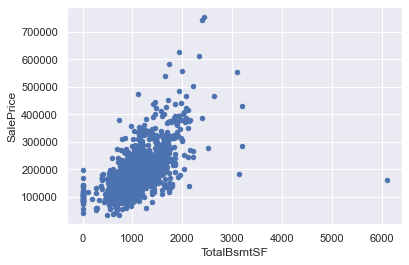

In [199]:
var = 'TotalBsmtSF'
data = pd.concat([train_set['SalePrice'], train_set[var]],axis = 1)
data.plot.scatter(x =var , y= 'SalePrice',ylim = 0.8)


(-0.5, 9.5, 0.0, 800000.0)

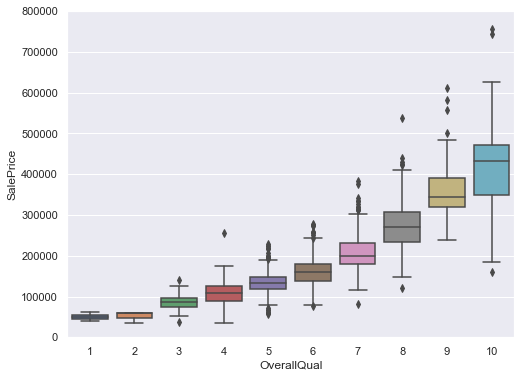

In [200]:
var = 'OverallQual'
data = pd.concat([train_set['SalePrice'],train_set[var]],axis = 1)
fig, ax = plt.subplots(figsize = (8,6))
fig = sns.boxplot(x = var, y= 'SalePrice', data = data)
fig.axis(ymin = 0, ymax = 800000)

<AxesSubplot:>

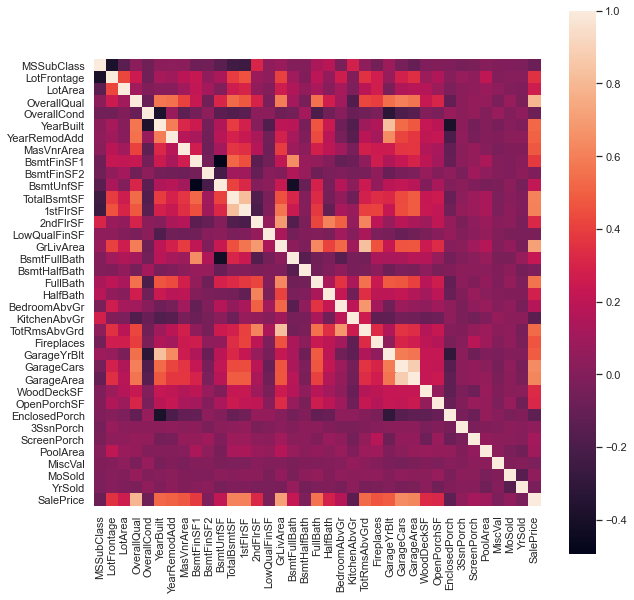

In [201]:
correlation_matrix = train_set.corr()
fig, ax = plt.subplots(1,1, figsize = (10,10))
sns.heatmap(correlation_matrix, xticklabels = correlation_matrix.columns, yticklabels = correlation_matrix.columns, square = True)

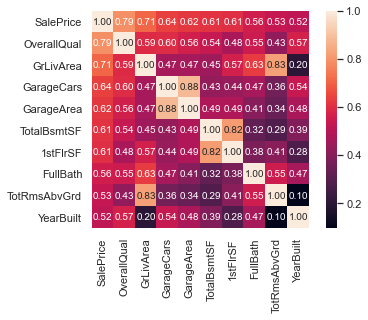

In [202]:
#create second heatmap, which shows the correlations between the variables
k = 10 #the amount of variables we want to show
cols = correlation_matrix.nlargest(k,'SalePrice')['SalePrice'].index
corr = np.corrcoef(train_set[cols].values.T)
sns.set(font_scale = 1)
heatmap = sns.heatmap(corr, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)



In [203]:
#calculate missing data and for each column, look what we should do with them
total = train_set.isnull().sum().sort_values(ascending=False)
percent = (train_set.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,NaN
MiscFeature,1406,NaN
Alley,1369,NaN
Fence,1179,NaN
FireplaceQu,690,NaN
LotFrontage,259,NaN
GarageType,81,NaN
GarageCond,81,NaN
GarageFinish,81,NaN
GarageQual,81,NaN


From this we look at each and every variable and understand whether we need these variables, or if they can be deleted from the
dataset

In [204]:
#dealing with missing data
train_set = train_set.drop((missing_data[missing_data['Total'] > 1]).index,1)
train_set = train_set.drop(train_set.loc[train_set['Electrical'].isnull()].index)
print(train_set.isnull().sum().max()) #just checking that there's no missing data missing...

0


In [205]:
#now, I am also going to delete the same features from the test set
test_set = test_set.drop((missing_data[missing_data['Total'] > 1]).index,1)

In [206]:
X_train = train_set.drop(['SalePrice'], axis = 1)
y_train = train_set['SalePrice']

In [223]:
# def flexible_pipeline(X, reg, scaler=StandardScaler(), encoder=OneHotEncoder()):
#     cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),encoder)
#     num_pipe = make_pipeline(SimpleImputer(strategy='mean'),scaler)
#     categorical = X.select_dtypes(include=["category"]).columns.tolist()
#     transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
#     return make_pipeline(transform, reg)
    
def flexible_pipeline(X, reg, scaler=StandardScaler()):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    X -- The training data
    reg -- any regression method
    scaler -- any scikit-learn feature scaling method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    
    categorical = X.select_dtypes(include=["category"]).columns.tolist()
    numerical = X.select_dtypes(exclude=["category"]).columns.tolist()
    
    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse= False, handle_unknown='ignore'))
])
        
    numerical_transformer = Pipeline(steps=[ 
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler',scaler)])
        
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)])
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('reg', reg)])
    return pipeline



In [ ]:

param_grid ={'reg__n_estimators':[10,100,1000],
                'reg__max_depth':[2,8,32,128]}
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ss = StandardScaler()
pipe = flexible_pipeline(X_train,RandomForestRegressor(random_state=1),scaler=ss)
cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) # Should be n_splits=5, but this speeds things up.
# GridSearchCV with pipelines will make sure that there is no data leakage
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cvs, n_jobs=-1).fit(X_train,y_train)
scores = grid.cv_results_['mean_test_score'].reshape(5, 4)
sns.heatmap(scores, xticklabels = param_grid['reg__n_estimators'], yticklabels = param_grid['reg__max_depth'],annot= True)


C:\Users\s166078\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [220]:
y_predictions = grid.predict(test_set)

In [ ]:
#create neural network for regression


In [221]:
submission = pd.DataFrame()
submission['Id'] = test_set.index
submission['SalePrice'] = y_predictions
submission.to_csv('submission.csv',index=False)